In [ ]:
! conda install -c conda-forge --yes hdbscan
! conda install -c conda-forge --yes spacy
! pip install allennlp
! python -m spacy download en
! python -m spacy download en_core_web_lg
! pip install --quiet keras tensorflow
! pip install --quiet hdmedians
! pip install --quiet joblib

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

import pandas as pd
pd.set_option('display.width', 800)

from joblib import Memory
mem = Memory('tasks-joblib', verbose=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import spacy
import numpy as np
import seaborn as sns
from scipy.spatial.distance import squareform, pdist

def is_verb(token):
    if not token.pos_ == 'VERB':
        return False
    if token.dep_ in ['acl', 'amod', 'prep'] and token.head.pos_ == 'NOUN':
        return False
    if token.dep_ in ['ccomp', 'advcl'] and token.head.pos_ == 'VERB':
        return False
    return True

def get_head(doc):
    return [t for t in doc if t.head == t][0]

def get_verbs(doc):
    return [t for t in doc if is_verb(t)]

def get_descendents(token):
    children = [c for c in token.children if not is_verb(c)]
    desc = [d for c in children for d in get_descendents(c)]
    return desc + [token]

def is_stop(t):
    return t.is_stop or len(str(t)) == 1 or t.pos_ in ['PUNCT', 'PART']

def get_objs(v):
    return [c for c in v.children 
            if c.dep_ in ['dobj', 'prep', 'ccomp', 'advcl']]

def get_np(verb):    
    children = get_objs(verb)
    other_verbs = [c for c in verb.children if c.dep_ in ['conj']]
    verbs = [verb]

    if other_verbs and not children:
        verbs += other_verbs
        children = [i for v in other_verbs for i in get_objs(v)]

    noun_phrase = [d for c in children 
                   for d in get_descendents(c) 
                   if not is_stop(d)]

    noun_phrase = sorted(noun_phrase, key=lambda t: t.i)

    return [' '.join(map(str, x)) for x in [verbs, noun_phrase]]

def parse_sent(sent):
    nps = [get_np(v) for v in get_verbs(sent)]    
    nouns,verbs = [],[]
    for v,n in nps:
        if n and not n in nouns:
            verbs += [v]
            nouns += [n]
    return list(zip(verbs, nouns))

@mem.cache()
def parse_tasks(tasks):
    return list(tasks.Task.map(nlp))

from numba import njit
from numpy.linalg import norm

@njit
def _cosine(A,B):
    m,_ = A.shape
    cosines = np.empty((m), dtype=np.double)
    for i in range(m):
        cosines[i] = 1 - np.dot(A[i], B[i])
    return cosines

@njit
def weighted_cosine(A,B, weights):
    return np.dot(_cosine(A,B), weights)

@njit
def max_cosine(A,B):
    return np.max(_cosine(A,B))

@njit
def _pdist(X, metric, *args):
    m,_,_ = X.shape
    k = 0
    dm = np.empty((m * (m - 1)) // 2, dtype=np.double)
    for i in range(0, m - 1):
        for j in range(i + 1, m):
            dm[k] = metric(X[i], X[j], *args)
            k = k + 1
    return dm                          

def safe_int(i):
    try: 
        return int(i)
    except ValueError:
        return None

@mem.cache()
def get_soc_wages(path):
    wages = pd.read_csv(path, sep='\t', engine='python')
    wages['soc'] = wages['occsoc'].map(safe_int)

    w = wages.dropna(subset=['soc', 'ln_hrwage_sic_purge'])
    w['soc'] = w.soc.astype(int)

    return mean_wage(w, 'soc', 'ln_hrwage_sic_purge')

def mean_wage(w, code, target):
    return (w[[code, target]]
            .groupby(code)
            .mean()
            .reset_index())

@mem.cache()
def get_occ_wages(path):
    return (pd.read_csv(path, sep='\t', engine='python')
            .dropna(subset = ['occ1990dd', 'ln_hrwage_sic_purge'])
            .pipe(lambda df: mean_wage(df, 'occ1990dd', 'ln_hrwage_sic_purge')))

In [4]:
tasks = pd.read_csv('tasks.txt', sep='\t')    
nlp = spacy.load('en_core_web_lg')

# For improving sentence parsing
# interesting = [0,2,4,8,9,10,22,55,61,81]
# [parsed_tasks[i] for i in interesting]

In [ ]:
from classification.embedding import PreEmbeddedVectorizer
from validation.data import get_soc_n
from validation.dot_data import get_desc_lookup

def get_occ_codes(df):
    return pd.DataFrame({ 'soc': df.soc6.unique()[0], 'occ1990dd': df.occ1990dd.unique()})

occ_xwalk = (pd.read_stata('census_us/dot1991_census_soc_crosswalk.dta')
             .groupby('soc6')
             .apply(get_occ_codes)
             .reset_index(drop=True)
             .dropna(subset = ['occ1990dd'])
             .pipe(lambda df: df.assign(occ1990dd = df.occ1990dd.astype(int))))    

def get_vecs(tasks):
    parsed = parse_tasks(tasks)
    parsed_tasks = [parse_sent(p) for p in parsed]
    vectorizer = PreEmbeddedVectorizer('./ss_models/sentencespace_100_us/model', 100, cache_dir='embed_cache')
    vecs = [[[vectorizer.fit_transform(t) for t in tup] for tup in li] for li in parsed_tasks]
    # each task should be a 2x100 array 
    a = np.array([np.vstack([v,n]) for vec in vecs for v,n in vec])
    not_failed = np.array([np.linalg.norm(i) > 1.4 for i in a])
    vecs = a[not_failed]

    soc_6 = get_soc_n(tasks['O*NET-SOC Code'], 6)
    socd = pd.DataFrame([{ 'soc': soc, 'task': ' '.join(t)} 
                         for soc,tasks in zip(soc_6, parsed_tasks) 
                         for t in tasks])[not_failed]

    return vecs, socd

vecs, socd = get_vecs(tasks)
wages_per_occ = get_occ_wages('census_us/census_2000_adjusted_wages.csv')

## Clustering Exploration

In [48]:
d = _pdist(vecs, max_cosine)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(n_clusters = CLUSTERS, linkage = 'average', memory = 'agglog', affinity='precomputed')
clusters_agg = clusterer.fit_predict(squareform(d))

In [49]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=1)
clusters_dbscan = clusterer.fit_predict(squareform(d))

In [51]:
from sklearn.manifold import TSNE

dat_tsne = TSNE(perplexity = 50, metric = 'precomputed').fit_transform(squareform(d))

In [ ]:
import seaborn as sns

sns.scatterplot(x = 0, y = 1, hue = 'cluster', data = pd.DataFrame(dat_tsne).assign(cluster = clusters_agg))

In [ ]:
from sklearn.cluster import SpectralClustering

clusterer = SpectralClustering(n_clusters = CLUSTERS, affinity='precomputed', n_jobs=-1)
clusters_spec = clusterer.fit_predict(squareform(aff))

## Regressing Wages on Tasks

In [ ]:
# HH per soc code
xx = (socd
 .assign(cluster = clusters)
 .groupby('soc')
 .apply(partial(hh, 'cluster'))
 .reset_index()
 .rename(columns = {0: 'HH'}))

sns.distplot(xx.HH)

In [106]:
bads = xx[xx.HH > 0.7].soc
socd.groupby('soc').apply(lambda df: df.count())
socd.assign(cluster = clusters)[socd.soc.isin(bads)].merge(xx, on='soc')

In [679]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras import models
from keras import layers
from keras import regularizers

def linear_model(dims):
    model = models.Sequential()
    model.add(layers.Dense(1, input_dim=dims, kernel_initializer='normal', kernel_regularizer=regularizers.l1(0.01)))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

model = KerasRegressor(build_fn=partial(linear_model, CLUSTERS), epochs=15, batch_size=5, validation_split=0, verbose=0)
preds = cross_val_predict(model, X, y, cv=10)

In [ ]:
model = linear_model(CLUSTERS)
history = model.fit(X, y, validation_split=0, epochs = 15, batch_size=5, verbose=0)

In [ ]:
w = model.get_layer(index=0).get_weights()[0].reshape(-1)
interpret_weights(w, lookup, 0.03)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from taskify.clustering import score_by_cluster_size

@mem.cache()
def agg_clusterer(vecs, n_clusters):
    d = _pdist(vecs, max_cosine)
    aff = np.exp(-d**2 * 3)
    clusterer = AgglomerativeClustering(n_clusters = n_clusters,
                                        linkage = 'average',
                                        memory = 'agglog',
                                        affinity='precomputed')
    clusters = clusterer.fit_predict(squareform(d))
    return clusters

@mem.cache()
def dbscan_clusterer(vecs, min_size):
    d = _pdist(vecs, max_cosine)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size, min_samples=1)
    clusters = clusterer.fit_predict(squareform(d))
    return clusters

In [ ]:
dbscan_scores = [score_by_cluster_size(socd, vecs, occ_xwalk, wages_per_occ, dbscan_clusterer, min_size=s) 
                 for s in [4, 8, 12]]

In [ ]:
from taskify.clustering import _score_by_cluster_size, make_regression_data, vectorize_tasks

_score_by_cluster_size(socd, vecs, occ_xwalk, wages_per_occ, clusters_dbscan)

In [7]:
scores = [score_by_cluster_size(socd, vecs, occ_xwalk, wages_per_occ, agg_clusterer, n_clusters=s) 
          for s in [64, 100, 128, 160, 256, 512, 1024, 2048]]

MemoryError: 

In [8]:
cluster_sizes = [64, 128, 256, 512, 1024]
for num,v in zip(cluster_sizes, scores):
    _,_,resids,coefs = v
    resids.to_csv(f'task-outputs/residuals_agg_{num}_b.csv', index=False)
    coefs.to_csv(f'task-outputs/coefs_agg_{num}_b.csv', index=False)

NameError: name 'scores' is not defined

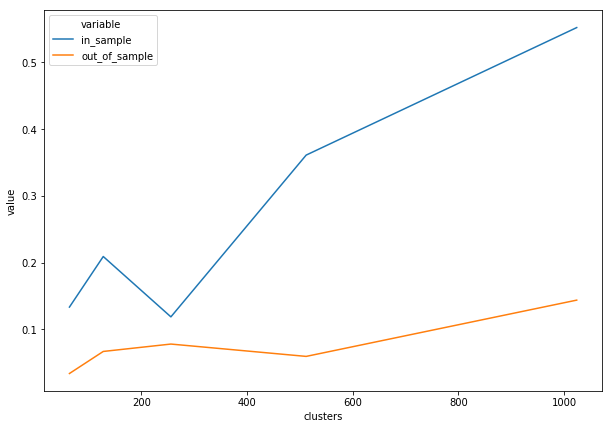

In [44]:
d = (pd.DataFrame([{'in_sample': t[1], 'out_of_sample': t[0], 'clusters': num} 
              for num,t in zip(cluster_sizes, scores)])
     .melt(value_vars=['in_sample', 'out_of_sample'], id_vars=['clusters']))

ax = sns.lineplot(x = 'clusters', y = 'value', hue='variable', data=d)